In [1]:
#ignoring warnings
import warnings
warnings.simplefilter('ignore')

#importing neccesary modules
import sys
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
from dateutil.parser import parse



import time
from datetime import datetime, timezone
from dateutil import parser
import oandapyV20.endpoints.instruments as instruments
import configparser
import json
from oandapyV20 import API
import oandapyV20.endpoints.positions as positions
import oandapyV20.endpoints.trades as trades
from oandapyV20.endpoints.pricing import PricingStream
import oandapyV20.endpoints.orders as orders
import oandapyV20.endpoints.accounts as accounts
from oandapyV20.contrib.factories import InstrumentsCandlesFactory
from oandapyV20.contrib.requests import MarketOrderRequest, TrailingStopLossDetails
from oandapyV20.exceptions import V20Error, StreamTerminated


In [2]:
#https://oanda-api-v20.readthedocs.io/en/latest/index.html
config = configparser.ConfigParser()
config.read('oanda.cfg')

client = API(access_token=config['oanda']['access_token'])

In [3]:
def get_data(_from, _to, granularity, instrument, save_csv=False):
    """
        Collect historical data for training
        _from="2018-01-01 00:00"    date and time to start collecting candles
        _to=""                      date and time to end the collection of candles, if "", then end will be now.
        save_csv if True will save csv file in current folder
    """
    if _to == "":
        _to = datetime.strptime(datetime.now().isoformat()[0:19] + "Z", '%Y-%m-%dT%H:%M:%SZ').strftime('%Y-%m-%dT%H:%M:%SZ')
    else:
        _to = datetime.strptime(parser.parse(_to).isoformat() + "Z", '%Y-%m-%dT%H:%M:%SZ').strftime('%Y-%m-%dT%H:%M:%SZ')
    params = {
    "granularity": granularity,
    "from": datetime.strptime(parser.parse(_from).isoformat() + "Z", '%Y-%m-%dT%H:%M:%SZ').strftime('%Y-%m-%dT%H:%M:%SZ'),
    "to": _to
    }
    
    df = pd.DataFrame(columns=["Date", 'Open', 'High', 'Low', 'Close', "Volume"])
    for r in InstrumentsCandlesFactory(instrument=instrument, params=params):
        rv = client.request(r)

        results = [{"Date":candle['time'][0:19], "Open":float(candle['mid']['o']),
                    "High":float(candle['mid']['h']), "Low":float(candle['mid']['l']),
                   "Close":float(candle['mid']['c']), "Volume": float(candle['volume'])
                   } for candle in r.response.get('candles')]
        df = df.append(pd.DataFrame(results), ignore_index=True)
    
    df.set_index("Date", inplace=True)
    if save_csv:
        df.to_csv(instrument + "_" + granularity + ".csv")
    return df

In [4]:
start = "2010-01-10 00:00"    #date and time to start collecting candles
end = ""                      #date and time to end the collection of candles, if "", then end will be now.
granularity = "H2"
instrument = "GBP_ZAR"


In [5]:
df = get_data(_from=start, _to=end, granularity=granularity, instrument=instrument, save_csv=False)
#df = pd.read_csv("EUR_USD_M15.csv", index_col=0)
print(df.shape)
df.head()

(39064, 5)


,Open,High,Low,Close,Volume
Date,,,,,
2010-01-10T18:00:00,11.78232,11.78565,11.76051,11.77635,180.0
2010-01-10T20:00:00,11.77394,11.79497,11.77394,11.78114,351.0
2010-01-10T22:00:00,11.78063,11.80462,11.76506,11.77190,1396.0
2010-01-11T00:00:00,11.77161,11.78483,11.73516,11.75047,1892.0
2010-01-11T02:00:00,11.75025,11.76098,11.71958,11.73752,1544.0


In [6]:
df = df.reset_index()

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39064 entries, 0 to 39063
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    39064 non-null  object 
 1   Open    39064 non-null  float64
 2   High    39064 non-null  float64
 3   Low     39064 non-null  float64
 4   Close   39064 non-null  float64
 5   Volume  39064 non-null  float64
dtypes: float64(5), object(1)
memory usage: 1.8+ MB


In [8]:
#df = pd.read_csv('XAU_EUR_H2.csv')

In [9]:
#df.info()

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='Close'>)

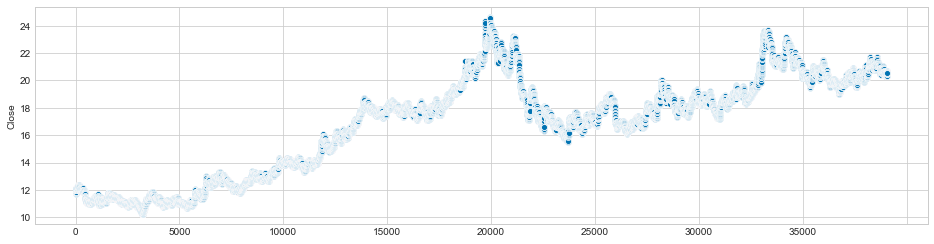

In [10]:
from sktime.utils.plotting import plot_series


y = df['Close']
plot_series(y)

In [11]:
import numpy as np


from sktime.forecasting.structural import UnobservedComponents




forecaster = UnobservedComponents( level='dtrend', freq_seasonal=[{'period': 12, 'harmonics': 1}, {'period': 56, 'harmonics': 2}])

forecaster.fit(y)
UnobservedComponents(...)

y_pred = forecaster.predict([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
            35, 36, 38, 40])

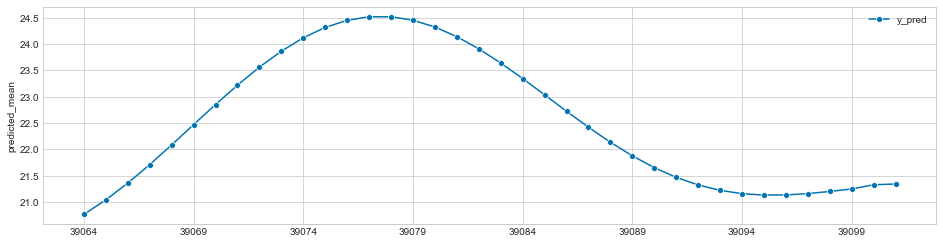

In [12]:
fig, ax = plot_series(y_pred, labels=["y_pred"])

In [13]:
forecaster.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                Unobserved Components Results                                
=============================================================================================
Dep. Variable:                                 Close   No. Observations:                39064
Model:                           deterministic trend   Log Likelihood               -9158.234
                   + stochastic freq_seasonal(12(1))   AIC                          18322.468
                   + stochastic freq_seasonal(56(2))   BIC                          18348.187
Date:                               Wed, 02 Mar 2022   HQIC                         18330.618
Time:                                       03:50:07                                         
Sample:                                            0                                         
                                             - 39064                                         
Covariance Type:                                 opg                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
sigma2.irregular            1.482e-13      0.000   3.92e-10      1.000      -0.001       0.001
sigma2.freq_seasonal_12(1)  2.594e-12   3.59e-08   7.23e-05      1.000   -7.03e-08    7.03e-08
sigma2.freq_seasonal_56(2)     0.0367      0.000    141.370      0.000       0.036       0.037
===================================================================================
Ljung-Box (L1) (Q):               36359.69   Jarque-Bera (JB):              1561.55
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               7.92   Skew:                            -0.45
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

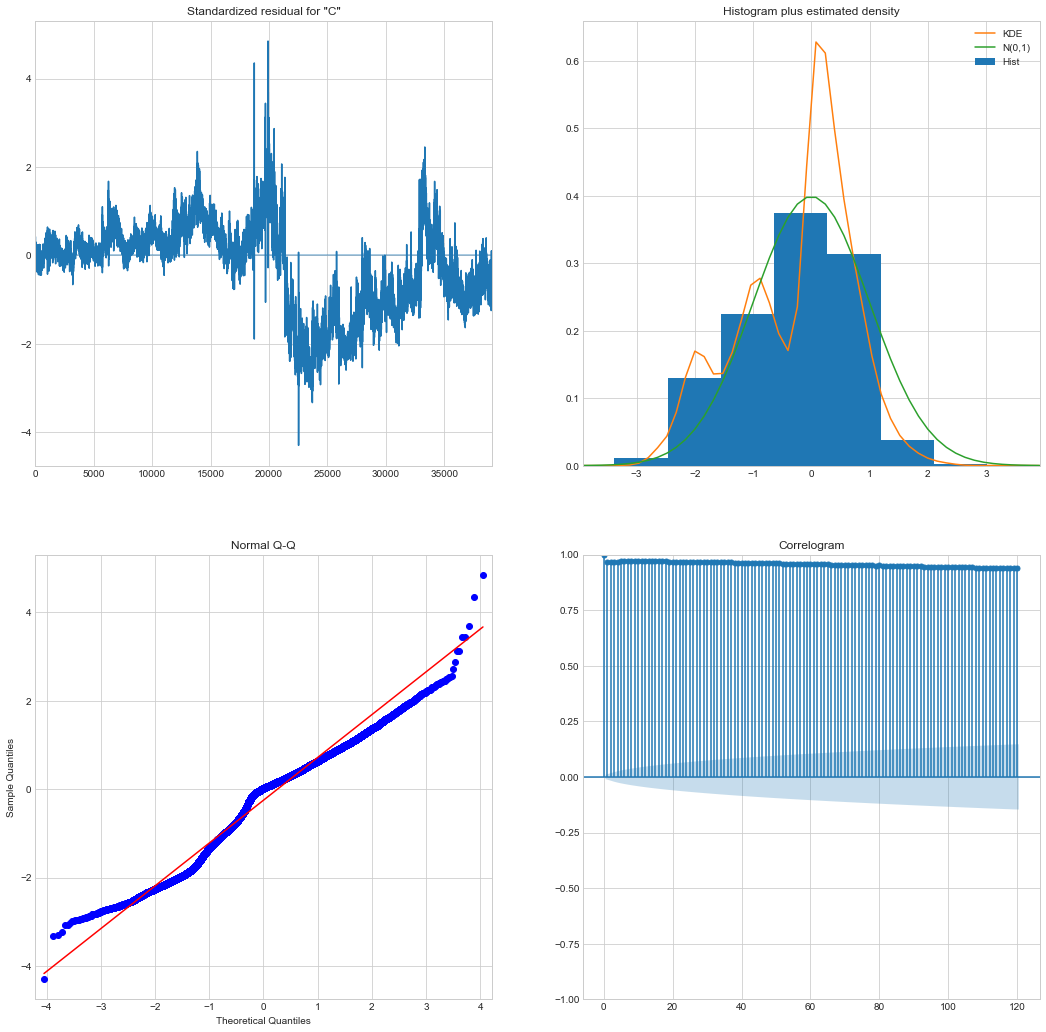

In [14]:
forecaster.plot_diagnostics(figsize=(18,18), lags = 120)